# Pose analysis panels for males

In [1]:
import cv2
import h5py
import umap
import random
import warnings
import numpy as np
import colorcet as cc
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.auto import tqdm
from sklearn.decomposition import PCA
from aging.size_norm.data import clean
from toolz import valmap, compose, groupby, curry, concat
from aging.organization.dataframes import get_age
from aging.size_norm.util import subsample, flatten
from aging.organization.paths import get_experiment_results_by_extraction_time
from aging.plotting import format_plots, PLOT_CONFIG, save_factory, figure, legend, COLORMAPS

warnings.simplefilter('ignore')

In [27]:
# ONTOGENY_AGE_CMAP = "cubehelix"
# ONTOGENY_AGE_CMAP = COLORMAPS.ont_male
ONTOGENY_AGE_CMAP = 'mako'

In [3]:
format_plots()
saver = save_factory(PLOT_CONFIG.save_path / "supp-fig1", tight_layout=False, dpi=600)

In [4]:
def smooth_clean(frame):
    frame = clean(frame, height_thresh=13)
    frame = cv2.GaussianBlur(frame, (21, 21), 1.5, 1)
    return frame


def zscore(arr):
    return (arr - np.nanmean(arr, axis=0)) / np.nanstd(arr, axis=0)

In [5]:
thinning = 5

In [17]:
def fit_pca(frames: dict[int, np.ndarray], is_recon=False):
    train = subsample(frames, subset=300, seed=0)
    if not is_recon:
        train = np.array(list(map(smooth_clean, train)))
    pca = PCA(n_components=10).fit(flatten(train))
    return pca


def apply_pca_factory(pca):
    return curry(valmap)(compose(pca.transform, flatten))


def compute_area(frames: np.ndarray, is_recon=False):
    if not is_recon:
        frames = np.array(list(map(smooth_clean, frames)))
    area = (frames > 15).sum(axis=(1, 2)) / 100
    return area

In [7]:
files = get_experiment_results_by_extraction_time(old=False)

In [8]:
list(files)

['ontogeny_females',
 'ontogeny_males',
 'dana_ontogeny_males',
 'dana_ontogeny_females',
 'dana_ontogeny_dana_ontogeny',
 'longtogeny_males',
 'longtogeny_v2_males',
 'longtogeny_v2_females',
 'wheel',
 'dlight',
 'jax_longtogeny',
 'klothos']

In [9]:
female_files = groupby(get_age, files['ontogeny_males'])

In [10]:
def load_frames(key, n_frames, path):
    with h5py.File(path, 'r') as h5f:
        return h5f[key][:n_frames]


def select_files(n_files: int, files: list):
    files = deepcopy(files)
    random.shuffle(files)
    return files[:n_files]

In [11]:
# select and load a subset of frames from a subset of files
n_files = 11
frames_per_file = 4_000

In [12]:
frame_loader = curry(load_frames)("frames", frames_per_file)
recon_frame_loader = curry(load_frames)("win_size_norm_frames_v7", frames_per_file)
file_selector = curry(select_files)(n_files)

file_aggregator = curry(map)(frame_loader)
recon_file_aggregator = curry(map)(recon_frame_loader)

In [13]:
random.seed(2)
frames_files = valmap(compose(list, file_selector), female_files)

In [14]:
frames_dict = valmap(compose(np.vstack, list, file_aggregator), frames_files)
recon_frames_dict = valmap(compose(np.vstack, list, recon_file_aggregator), frames_files)

In [18]:
area_dict = valmap(compute_area, frames_dict)
recon_area_dict = valmap(lambda frames: compute_area(frames, True), recon_frames_dict)

In [19]:
area_dict[12]

array([6.29, 5.05, 5.02, ..., 6.49, 6.57, 6.39])

In [20]:
pca = fit_pca(frames_dict, is_recon=False)
apply_pca = apply_pca_factory(pca)
og_frame_pcs = apply_pca(frames_dict)

In [21]:
recon_pca = fit_pca(recon_frames_dict, is_recon=True)
apply_pca = apply_pca_factory(recon_pca)
recon_frame_pcs = apply_pca(recon_frames_dict)

## Plot pca pre- and post-

In [29]:
_pcs = np.vstack(list(og_frame_pcs.values()))
ages = np.array(list(concat([k] * len(v) for k, v in og_frame_pcs.items())))

In [23]:
permutation = np.random.permutation(len(_pcs))[::thinning]

webf NOT subset; don't know how to subset; dropped


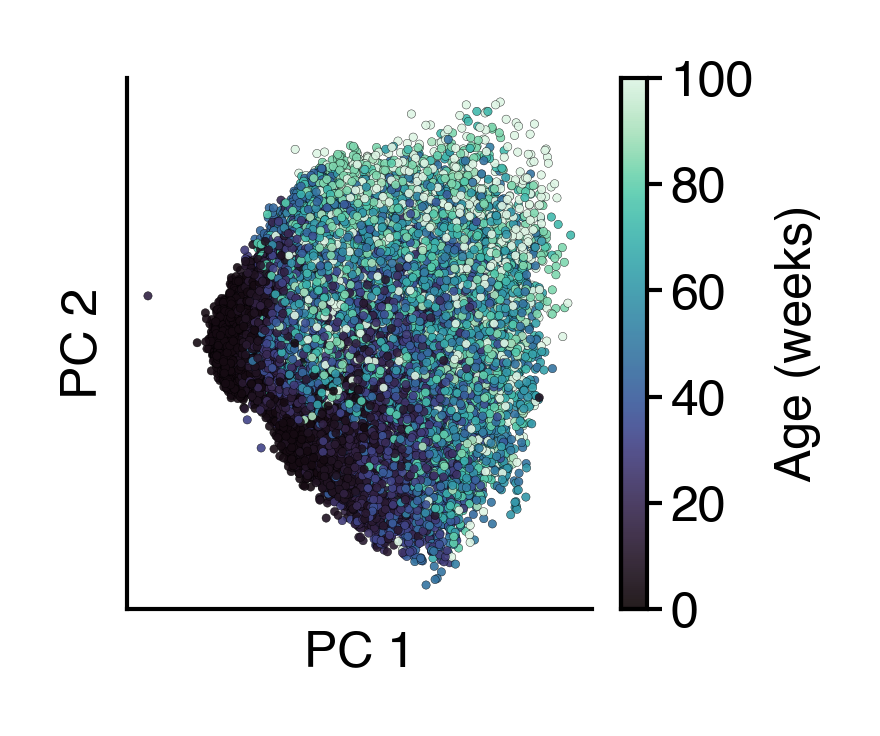

In [30]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *_pcs[permutation, :2].T,
    c=ages[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0,
    vmax=90,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, 'pre-model-pcs-across-age', dpi=700);

In [25]:
_pcs = np.vstack(list(recon_frame_pcs.values()))
ages = np.array(list(concat([k] * len(v) for k, v in recon_frame_pcs.items())))

webf NOT subset; don't know how to subset; dropped


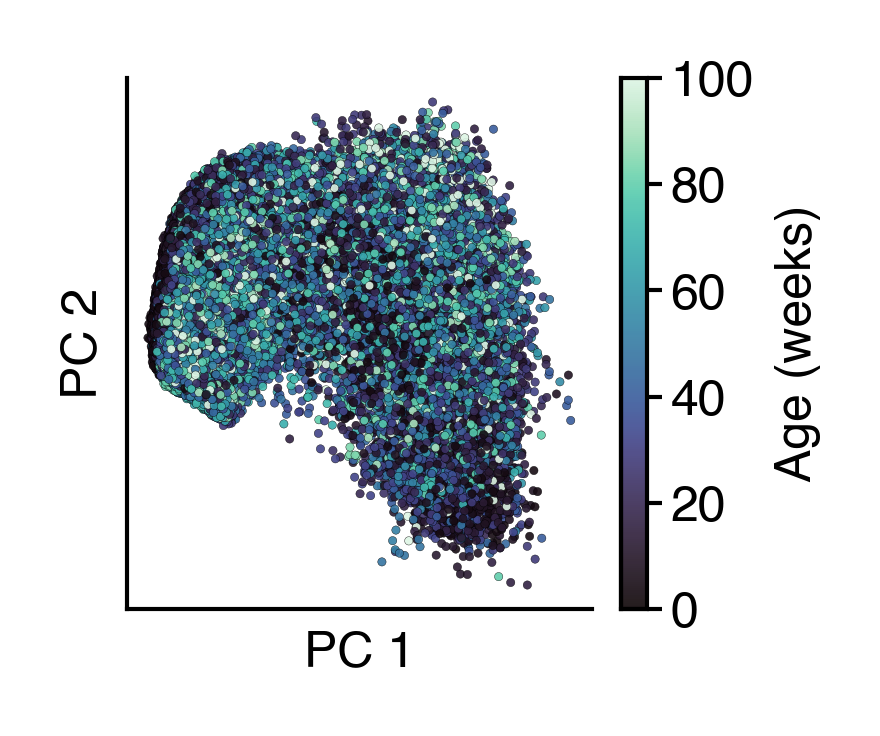

In [28]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *_pcs[permutation, :2].T,
    c=ages[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0,
    vmax=90,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="PC 1", ylabel="PC 2")
sns.despine()
saver(fig, 'post-model-pcs-across-age', dpi=700);

## Plot UMAP pre- and post-

In [31]:
_pcs = np.vstack(list(og_frame_pcs.values()))
ages = np.array(list(concat([k] * len(v) for k, v in og_frame_pcs.items())))
sizes = np.array(list(concat(area_dict[k] for k in og_frame_pcs.keys())))

umap_mdl = umap.UMAP(random_state=0)
pre_latents = umap_mdl.fit_transform(_pcs[permutation])

webf NOT subset; don't know how to subset; dropped


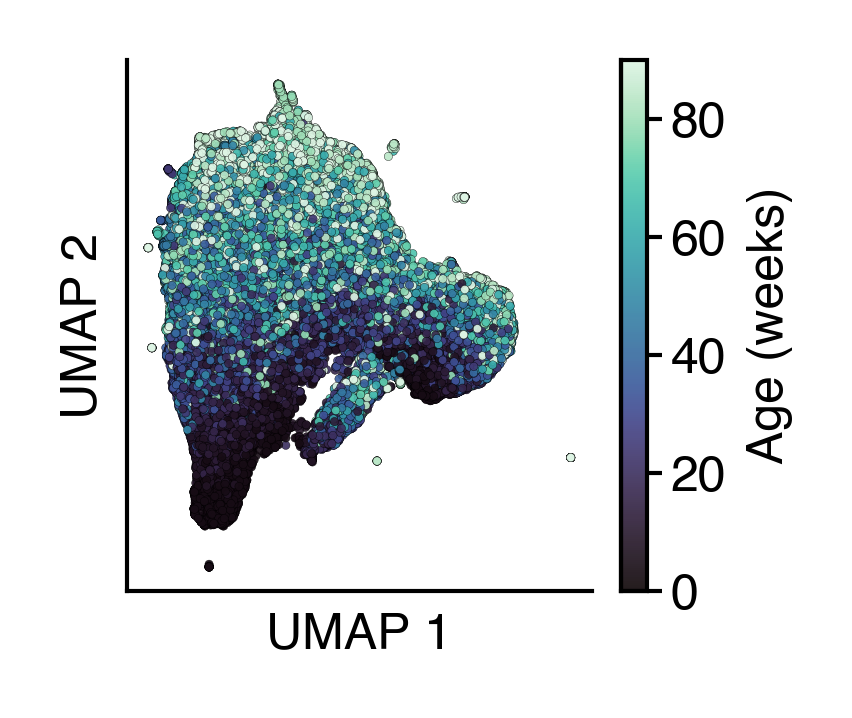

In [32]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *pre_latents.T,
    c=ages[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0,
    vmax=90,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, 'pre-model-umap-across-age', dpi=700);

webf NOT subset; don't know how to subset; dropped


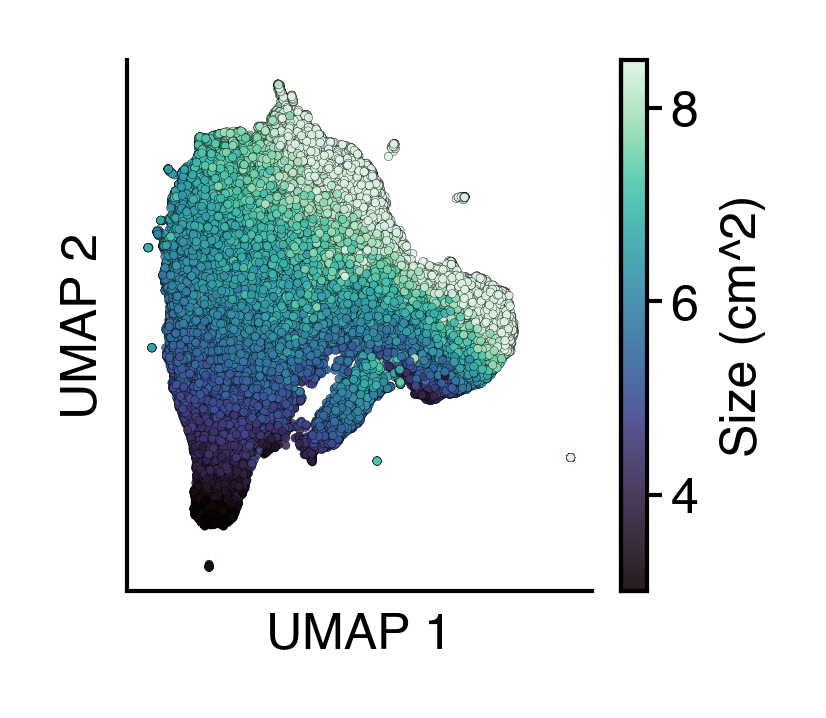

In [36]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *pre_latents.T,
    c=sizes[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=3,
    vmax=8.5,
)
fig.colorbar(im, label="Size (cm^2)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, 'pre-model-umap-across-size', dpi=700);

In [37]:
_pcs = np.vstack(list(recon_frame_pcs.values()))
ages = np.array(list(concat([k] * len(v) for k, v in recon_frame_pcs.items())))
sizes = np.array(list(concat(area_dict[k] for k in recon_frame_pcs.keys())))

umap_mdl = umap.UMAP(random_state=0)
post_latents = umap_mdl.fit_transform(_pcs[permutation])

webf NOT subset; don't know how to subset; dropped


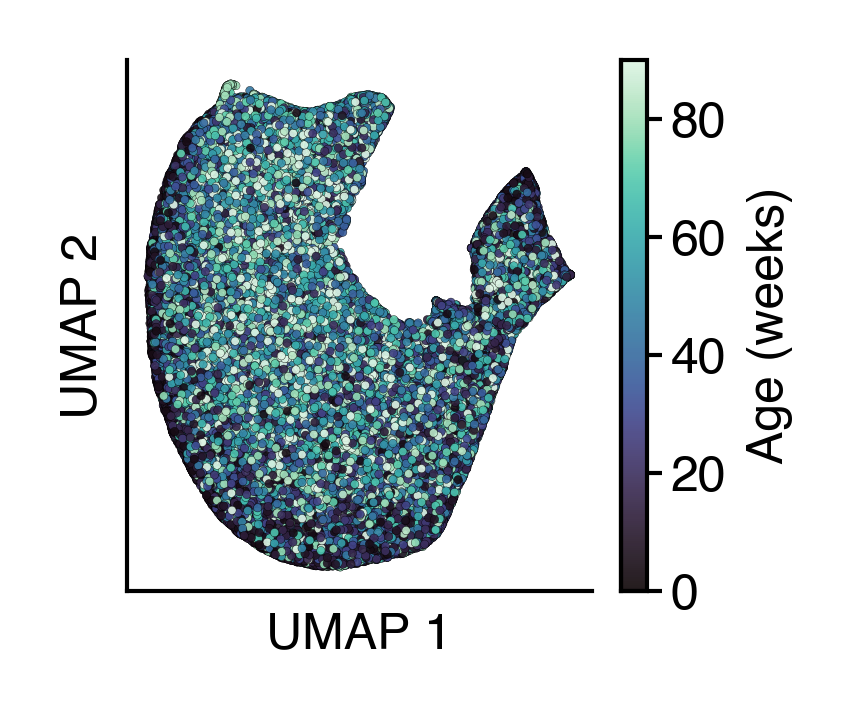

In [38]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *post_latents.T,
    c=ages[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=0,
    vmax=90,
)
fig.colorbar(im, label="Age (weeks)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, 'post-model-umap-across-age', dpi=700);

webf NOT subset; don't know how to subset; dropped


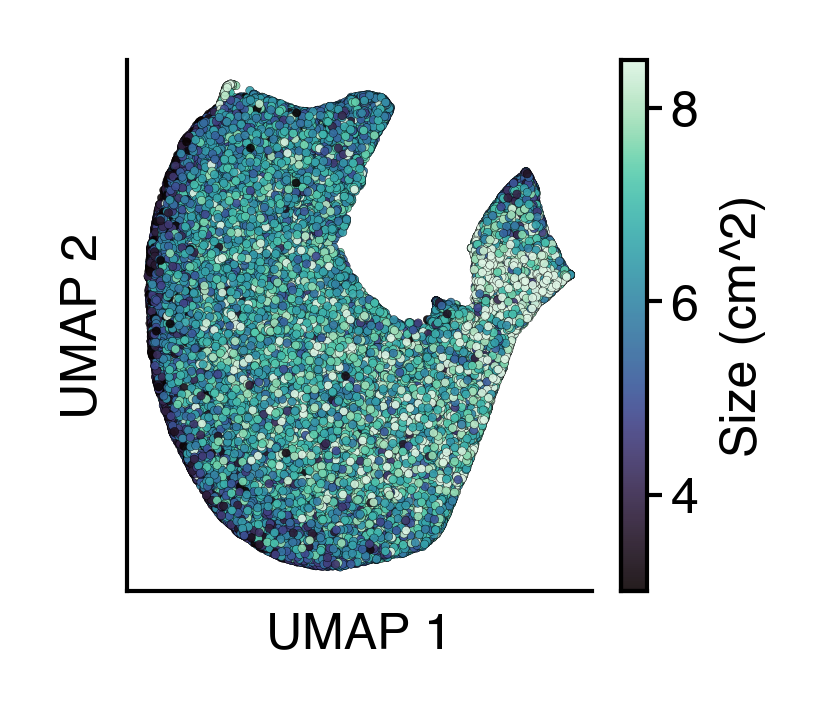

In [39]:
fig = figure(1.25, 1.15)
ax = fig.gca()
im = ax.scatter(
    *post_latents.T,
    c=sizes[permutation],
    cmap=ONTOGENY_AGE_CMAP,
    s=1,
    lw=0.05,
    ec="k",
    alpha=0.9,
    rasterized=True,
    vmin=3,
    vmax=8.5,
)
fig.colorbar(im, label="Size (cm^2)", ax=ax)
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, 'post-model-umap-across-size', dpi=700);

## k-means clustering of post-NN space, apply coloring to pre-NN space

In [40]:
from sklearn.cluster import k_means

In [41]:
def get_avg_frames(labels, frames):
    np.random.seed(0)
    avgs = {}
    counts = {}
    start = 0
    unique_labels = np.unique(labels)
    for k, v in frames.items():
        label_subset = labels[start:start+len(v)]
        start += len(v)
        for i in unique_labels:
            if i not in avgs:
                avgs[i] = np.sum(v[label_subset == i], axis=0)
                counts[i] = np.sum(label_subset == i)
            else:
                avgs[i] = avgs[i] + np.sum(v[label_subset == i], axis=0)
                counts[i] = counts[i] + np.sum(label_subset == i)
    return {k: v / counts[k] for k, v in avgs.items()}

In [42]:
_pcs = np.vstack(list(recon_frame_pcs.values()))
ages = np.array(list(concat([k] * len(v) for k, v in recon_frame_pcs.items())))

centroid, labels, inertia = k_means(
    _pcs, n_clusters=5, random_state=0
)

In [43]:
recon_frame_clusters = get_avg_frames(labels, recon_frames_dict)
frame_clusters = get_avg_frames(labels, frames_dict)

webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped


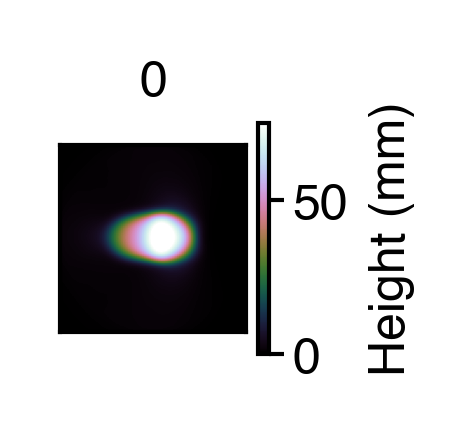

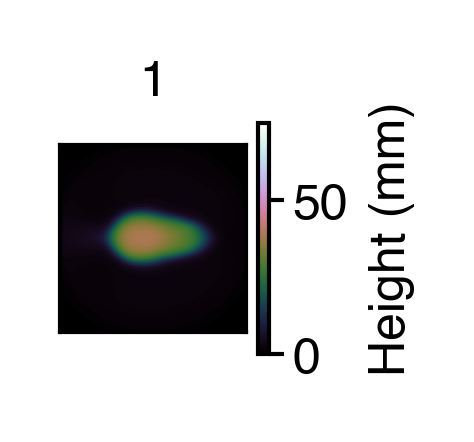

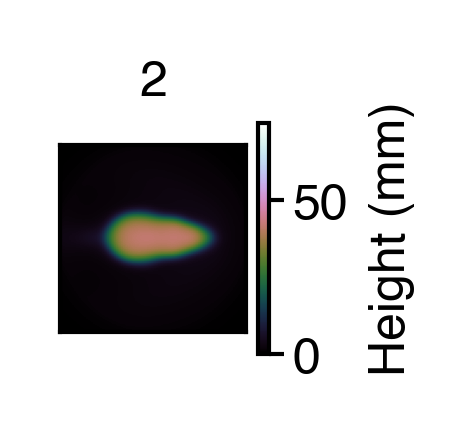

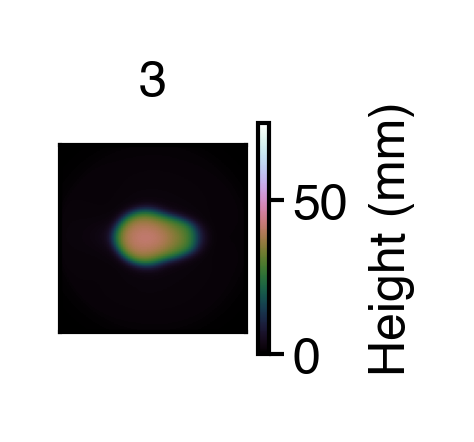

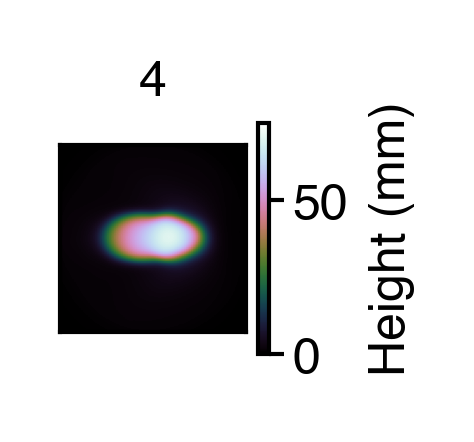

In [50]:
for k, v in frame_clusters.items():
    fig = figure(0.5, 0.5)
    ax = fig.gca()
    im = ax.imshow(v, vmax=75, cmap='cubehelix', vmin=0)
    ax.set(xticks=[], yticks=[])
    fig.colorbar(im, ax=ax, label="Height (mm)")
    plt.title(k)
    saver(fig, f"avg-cluster-{k}-pre-pose-post-fit-to-pre");

webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped
webf NOT subset; don't know how to subset; dropped


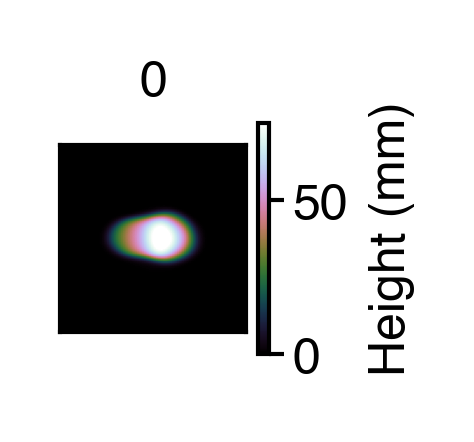

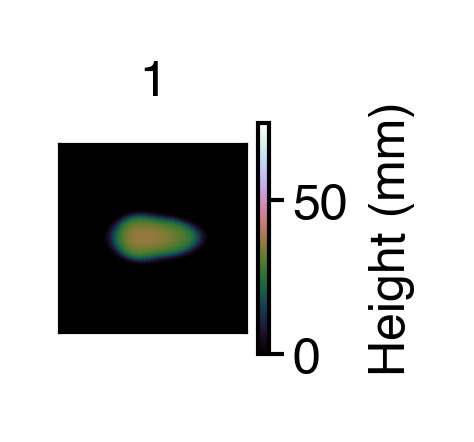

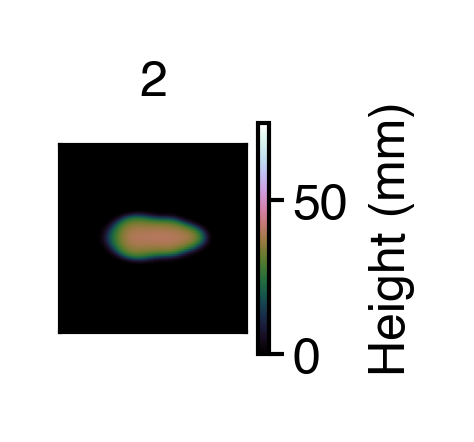

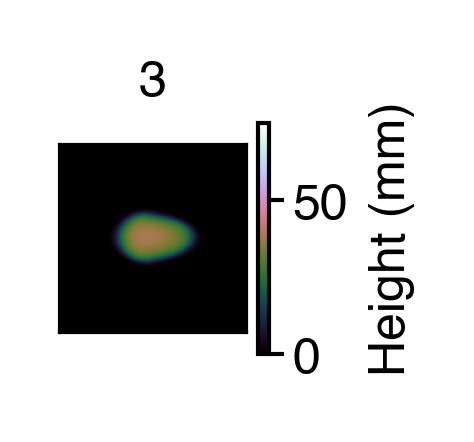

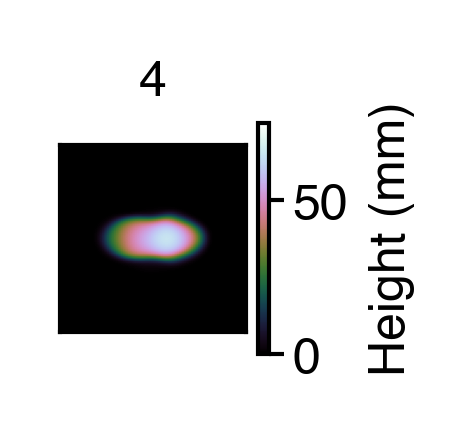

In [51]:
for k, v in recon_frame_clusters.items():
    fig = figure(0.5, 0.5)
    ax = fig.gca()
    im = ax.imshow(v, vmax=75, cmap='cubehelix', vmin=0)
    ax.set(xticks=[], yticks=[])
    fig.colorbar(im, ax=ax, label="Height (mm)")
    plt.title(k)
    saver(fig, f"avg-cluster-{k}-post-pose-post-fit-to-pre");

In [46]:
centroid.shape

(5, 10)

In [47]:
pre_centroids = {
    k: np.mean(pre_latents[labels[permutation] == k], axis=0)
    for k in sorted(np.unique(labels))
}
pre_centroids = np.array(list(pre_centroids.values()))

post_centroids = {
    k: np.mean(post_latents[labels[permutation] == k], axis=0)
    for k in sorted(np.unique(labels))
}
post_centroids = np.array(list(post_centroids.values()))

webf NOT subset; don't know how to subset; dropped


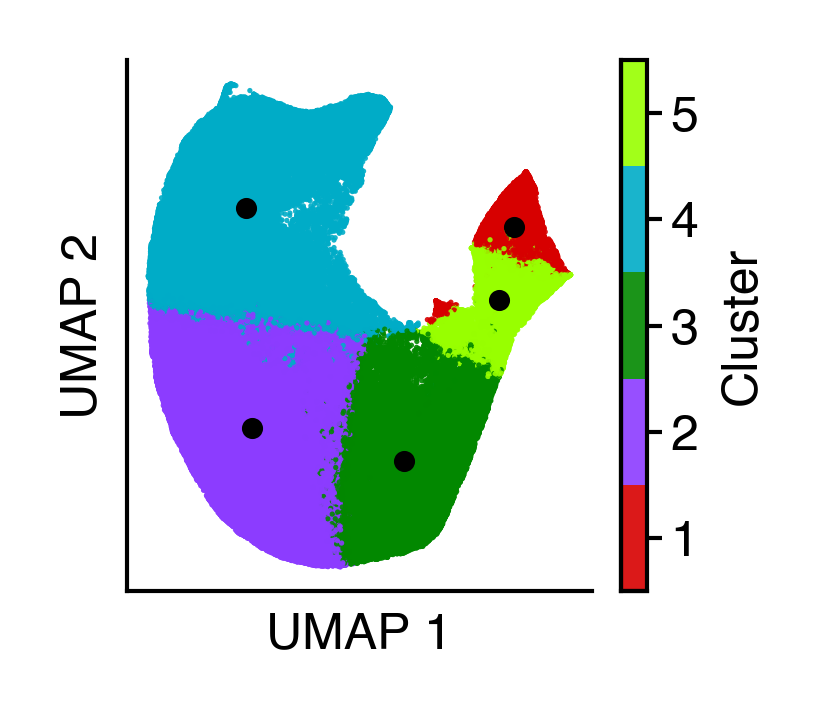

In [48]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*post_centroids[:, :2].T, color="k", s=3, zorder=2)
im = ax.scatter(
    *post_latents.T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, "post-model-umap-across-pose-clusters-post-fit", dpi=700);

webf NOT subset; don't know how to subset; dropped


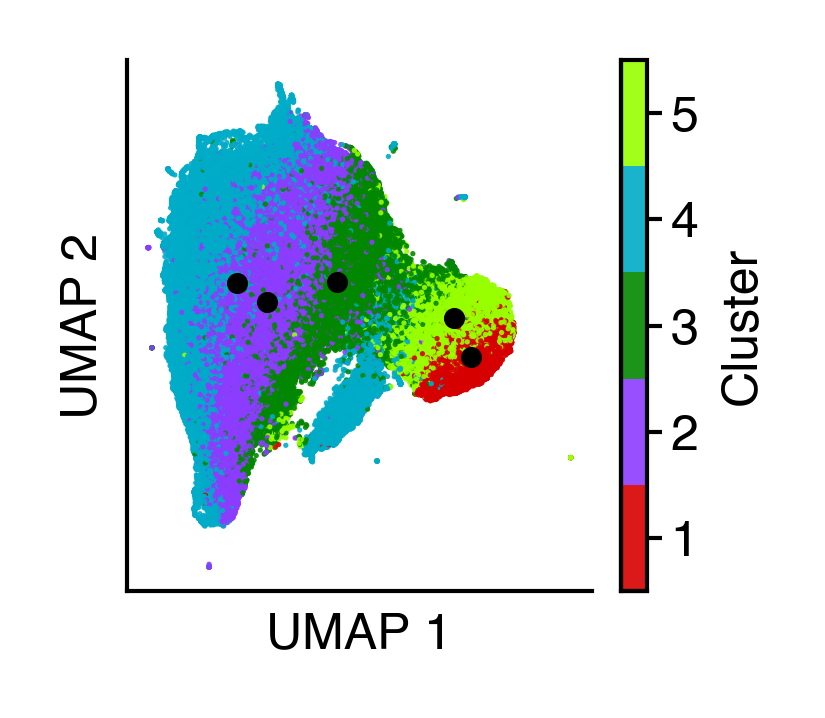

In [49]:
fig = figure(1.25, 1.15)
ax = fig.gca()
ax.scatter(*pre_centroids[:, :2].T, color='k', s=3, zorder=2)
im = ax.scatter(
    *pre_latents.T,
    c=labels[permutation],
    cmap=cc.cm.glasbey,
    s=0.4,
    lw=0,
    # ec="k",
    alpha=0.9,
    rasterized=True,
    vmax=256
)
cb = fig.colorbar(im, label="Cluster", ax=ax, boundaries=[0, 1, 2, 3, 4, 5])
cb.set_ticks(np.arange(0.5, 5, 1))
cb.set_ticklabels((np.arange(0.5, 5, 1) + 0.5).astype(int))
ax.set(xticks=[], yticks=[], xlabel="UMAP 1", ylabel="UMAP 2")
sns.despine()
saver(fig, "pre-model-umap-across-pose-clusters-post-fit", dpi=700);

## Area transform

In [36]:
import polars as pl

In [14]:
colors = ['#c7eae5','#008C8D']
female_cmap = sns.blend_palette(colors, as_cmap=True)

In [38]:
version = 11
df = pl.scan_parquet(
    f"/n/groups/datta/win/longtogeny/data/ontogeny/version_{version:02d}/ontogeny_males_syllable_df_v00.parquet"
)

In [39]:
areas = (
    df.group_by(["age", "session_name", "uuid"])
    .agg([pl.col("area_px").median(), pl.col("recon_area").median()])
    .group_by("age")
    .agg([pl.col("area_px").mean(), pl.col("recon_area").mean()])
    .filter(pl.col("age") < 100)
    .collect()
)

melted_areas = areas.to_pandas().melt(id_vars='age', value_vars=['area_px', 'recon_area'])

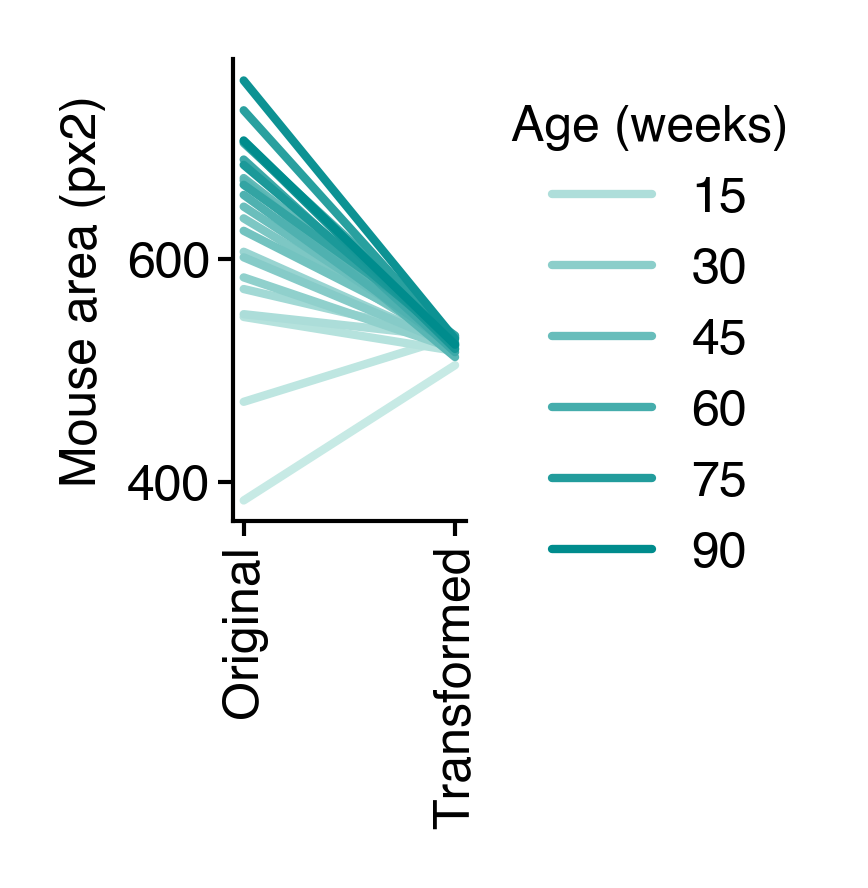

In [40]:
fig = figure(0.5, 1)
ax = sns.lineplot(
    data=melted_areas, x="variable", y="value", hue="age", palette=female_cmap
)
ax.set(ylabel="Mouse area (px2)", xlabel="", xticklabels=["Original", "Transformed"])
plt.xticks(rotation=90)
legend(ax, title="Age (weeks)")
sns.despine()
saver(fig, "intra-age-area-mean");

## Extract dynamics

In [15]:
import pandas as pd
import polars as pl
from aging.behavior.scalars import compute_scalars

In [16]:
dynamics_frame_loader = curry(load_frames)("frames", frames_per_file * 3)
dynamics_recon_frame_loader = curry(load_frames)(
    "win_size_norm_frames_v7", frames_per_file * 3
)
dynamics_file_aggregator = curry(map)(dynamics_frame_loader)
dynamics_recon_file_aggregator = curry(map)(dynamics_recon_frame_loader)

In [17]:
frames_dict = valmap(compose(list, dynamics_file_aggregator), frames_files)
recon_frames_dict = valmap(compose(list, dynamics_recon_file_aggregator), frames_files)

In [18]:
rolling_win_size = 40 * 30

dynamics_corr_df = []
dynamics_rolling_corr_df = []

for age, frames_list in tqdm(frames_dict.items()):
    for i, (_og_frames, _recon_frames) in enumerate(
        zip(frames_list, recon_frames_dict[age])
    ):
        scalars = compute_scalars(_og_frames.copy(), is_recon=False, height_thresh=12)
        recon_scalars = compute_scalars(
            _recon_frames.copy(), is_recon=False, height_thresh=12
        )

        # aggregate correlations for all scalars
        # alse compute rolling correlations to find plottable examples
        tmp_corrs = {}
        rolling_corrs = {}

        for k, v in scalars.items():
            tmp_corrs[k] = pd.Series(v).corr(pd.Series(recon_scalars[k]))
            pl_df = pl.DataFrame({k: v, f"{k}_recon": recon_scalars[k]})
            corr_val = pl_df.with_columns(
                [
                    pl.rolling_corr(
                        k, f"{k}_recon", window_size=rolling_win_size
                    ).alias("corr")
                ]
            )["corr"]
            rolling_corrs[k] = np.asarray(corr_val)
        tmp_corrs["avg"] = np.mean(list(tmp_corrs.values()))
        tmp_corrs["age"] = age

        dynamics_corr_df.append(tmp_corrs)

        rolling_corrs = pd.DataFrame(rolling_corrs)
        rolling_corrs["avg"] = rolling_corrs.mean(1)
        rolling_corrs["age"] = age
        rolling_corrs["file_index"] = i

        dynamics_rolling_corr_df.append(rolling_corrs)

dynamics_corr_df = pd.DataFrame(dynamics_corr_df)
dynamics_rolling_corr_df = pd.concat(dynamics_rolling_corr_df)

  0%|          | 0/24 [00:00<?, ?it/s]

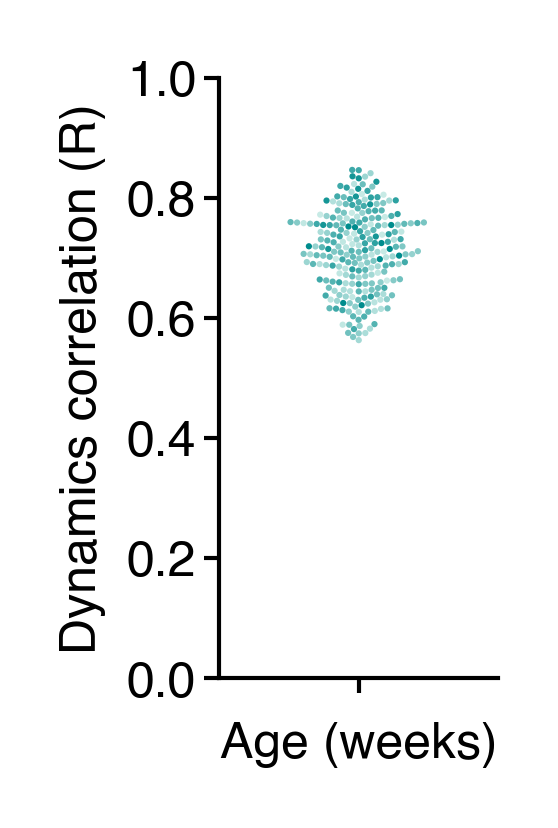

In [19]:
fig = figure(0.6, 1.3)
ax = sns.swarmplot(
    data=dynamics_corr_df,
    y="avg",
    hue="age",
    palette=female_cmap,
    size=0.75,
    legend=False,
)
ax.set(ylim=(0, 1), xlabel="Age (weeks)", ylabel="Dynamics correlation (R)")
sns.despine()
saver(fig, "dynamics-correlation-vs-age-swarmplot");

### Individual examples of dynamics

In [46]:
def get_best_example(age):
    best_young_session = (
        dynamics_rolling_corr_df.query("age == @age")
        .groupby("file_index")["width"]
        .max()
        .idxmax()
    )
    end_idx = np.argmax(
        dynamics_rolling_corr_df.query(
            "age == @age & file_index == @best_young_session"
        )["width"]
    )
    return best_young_session, end_idx


def compute_example(data, recon_data):
    scalars = compute_scalars(data.copy(), is_recon=False, height_thresh=12)
    recon_scalars = compute_scalars(recon_data.copy(), is_recon=False, height_thresh=12)
    start = end_idx - rolling_win_size
    w1 = zscore(scalars["width"][start:end_idx])
    w2 = zscore(recon_scalars["width"][start:end_idx])

    w1 = pd.Series(w1).rolling(8).mean()
    w2 = pd.Series(w2).rolling(8).mean()

    ww1 = scalars["width"][start:end_idx]
    ww2 = recon_scalars["width"][start:end_idx]

    ww1 = pd.Series(ww1).rolling(8).mean()
    ww2 = pd.Series(ww2).rolling(8).mean()

    return w1, w2, ww1, ww2

In [47]:
time = np.arange(rolling_win_size) / 30

In [48]:
best_young_session, end_idx = get_best_example(4)

data = frames_dict[4][best_young_session]
recon_data = recon_frames_dict[4][best_young_session]

w1, w2, ww1, ww2 = compute_example(data, recon_data)

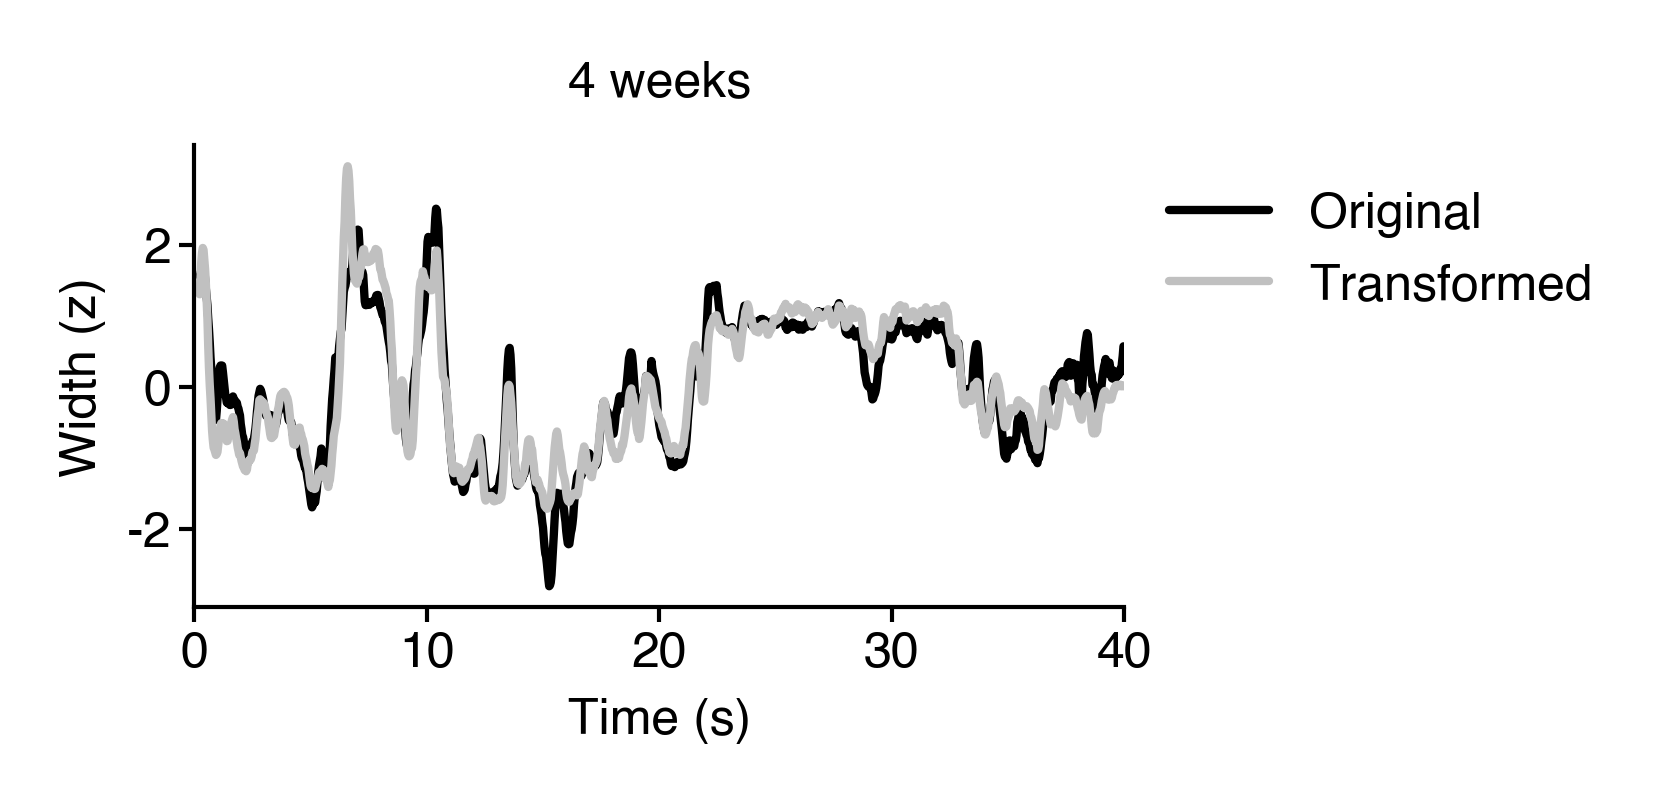

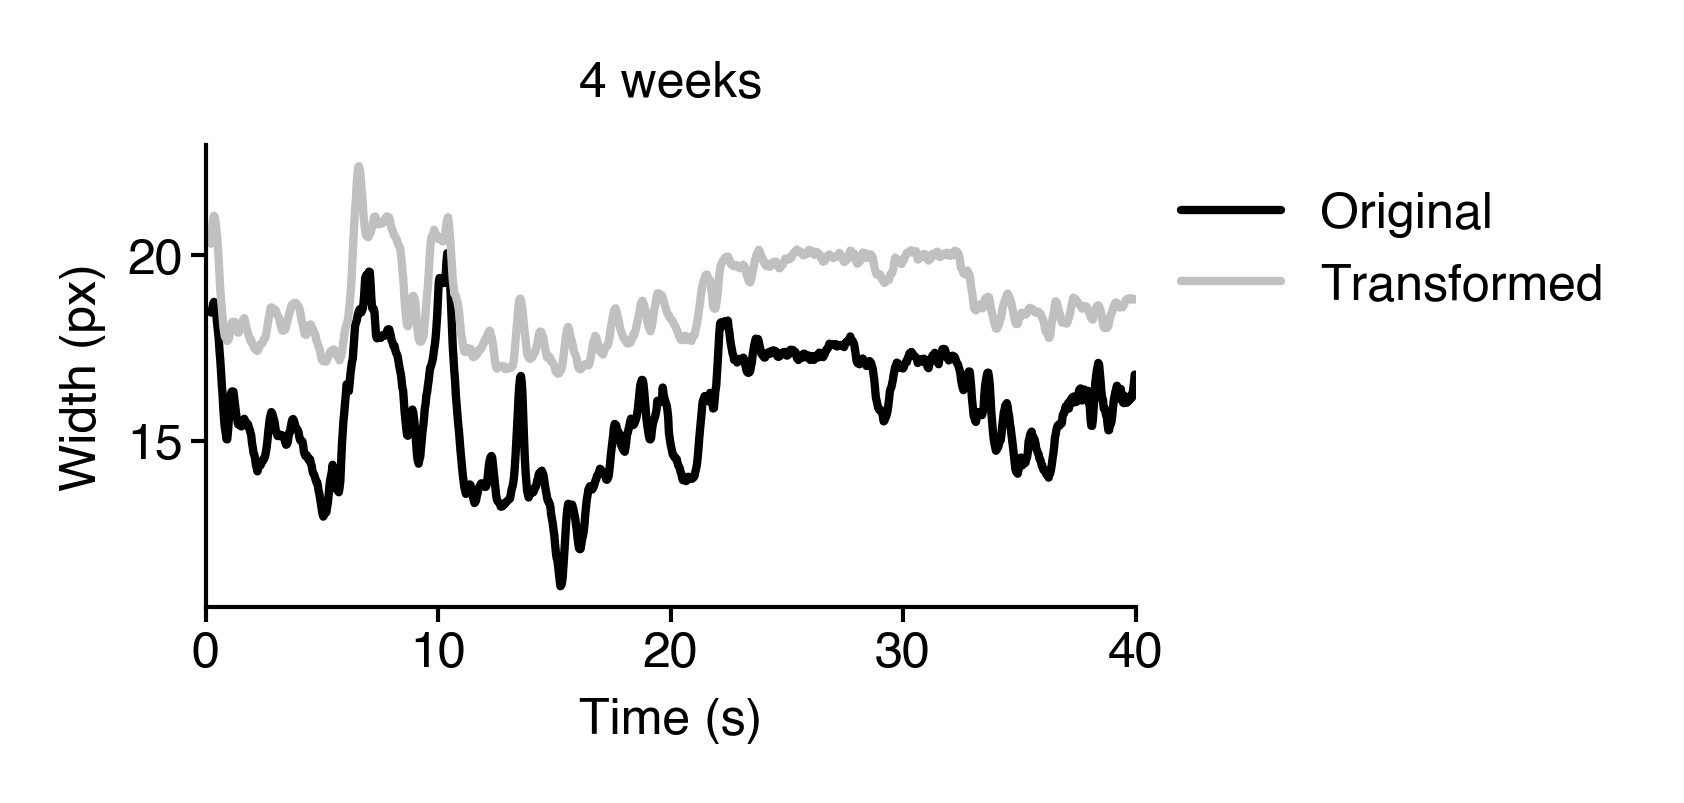

In [49]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, w1, label="Original", color="k")
ax.plot(time, w2, label="Transformed", color="silver")
ax.set(xlabel="Time (s)", ylabel="Width (z)", title="4 weeks", xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, "dynamics-example-4-wks");

fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, ww1, label="Original", color="k")
ax.plot(time, ww2, label="Transformed", color="silver")
ax.set(xlabel="Time (s)", ylabel="Width (px)", title="4 weeks", xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, "dynamics-example-raw-4-wks");

In [50]:
best_young_session, end_idx = get_best_example(84)

data = frames_dict[84][best_young_session]
recon_data = recon_frames_dict[84][best_young_session]

w1, w2, ww1, ww2 = compute_example(data, recon_data)

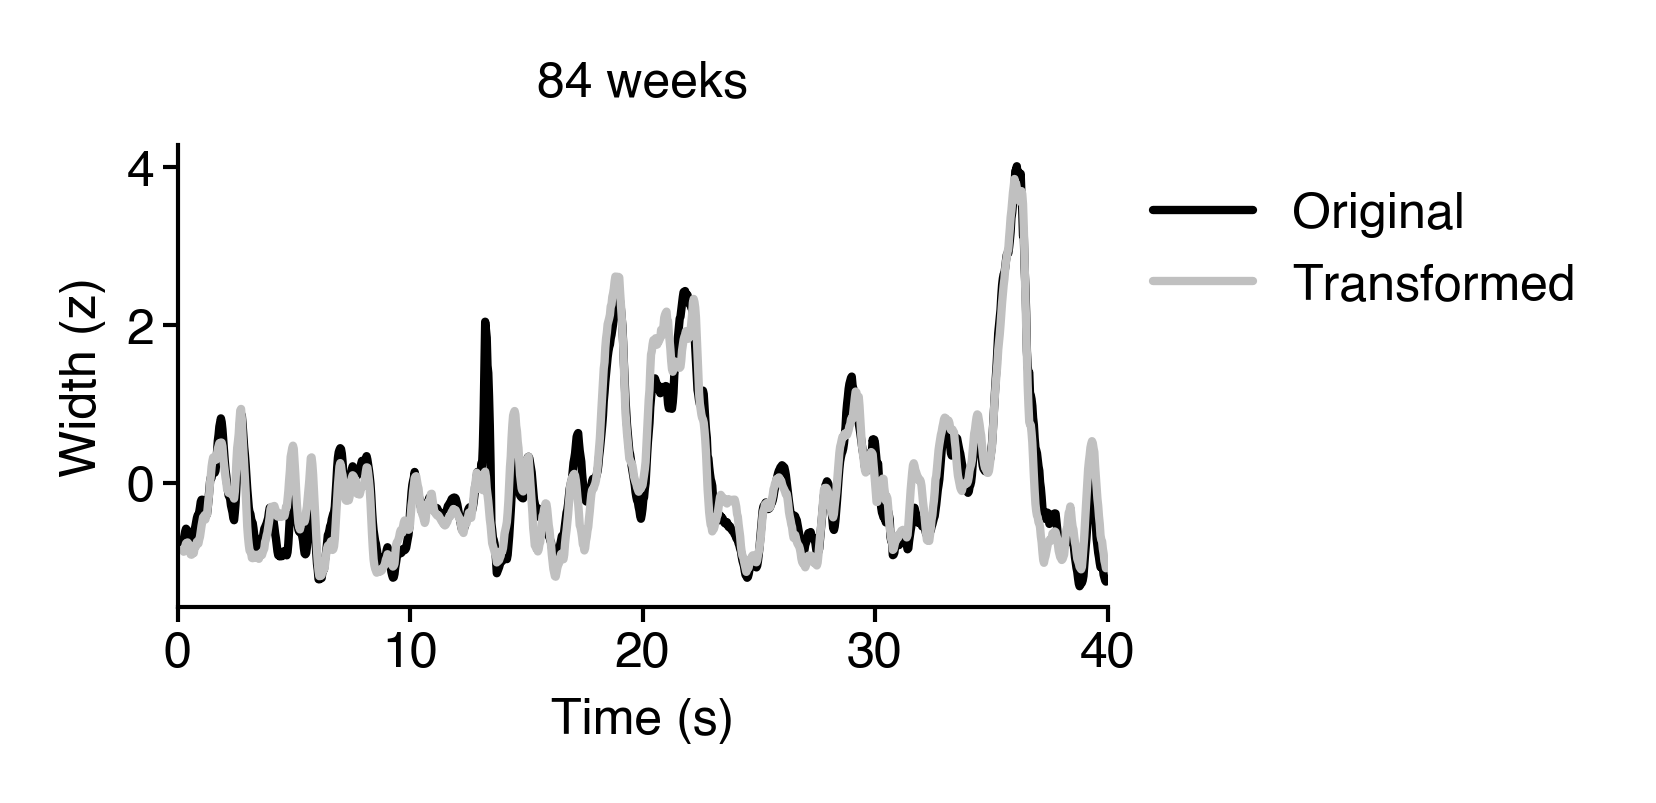

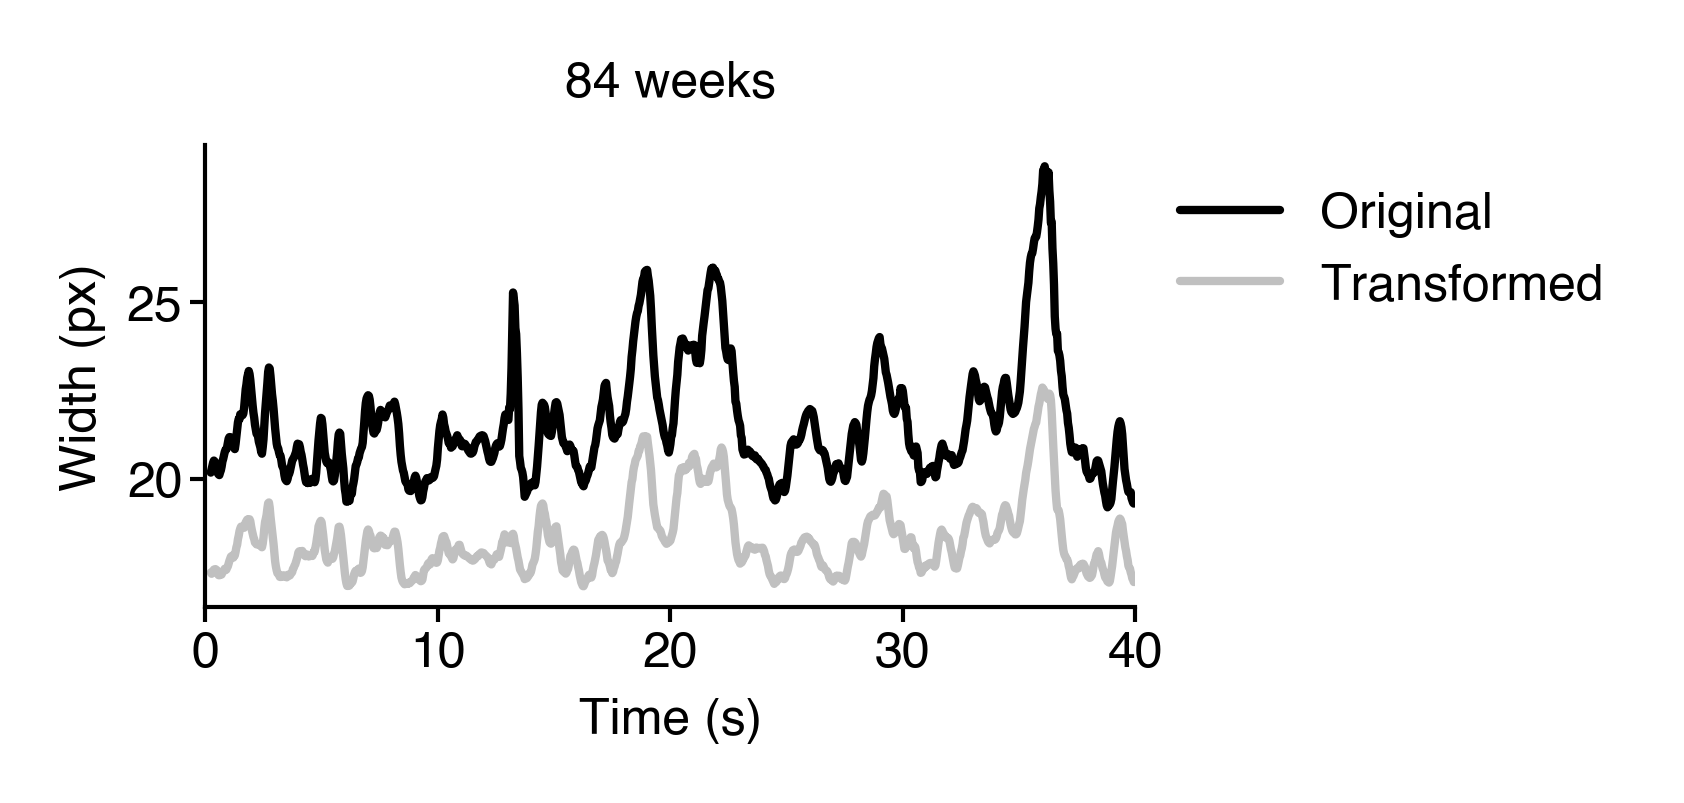

In [51]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, w1, label='Original', color='k')
ax.plot(time, w2, label='Transformed', color='silver')
ax.set(xlabel="Time (s)", ylabel="Width (z)", title='84 weeks', xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, 'dynamics-example-84-wks');

fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, ww1, label='Original', color='k')
ax.plot(time, ww2, label='Transformed', color='silver')
ax.set(xlabel="Time (s)", ylabel="Width (px)", title='84 weeks', xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, 'dynamics-example-raw-84-wks');

In [52]:
best_young_session, end_idx = get_best_example(12)

data = frames_dict[12][best_young_session]
recon_data = recon_frames_dict[12][best_young_session]

w1, w2, ww1, ww2 = compute_example(data, recon_data)

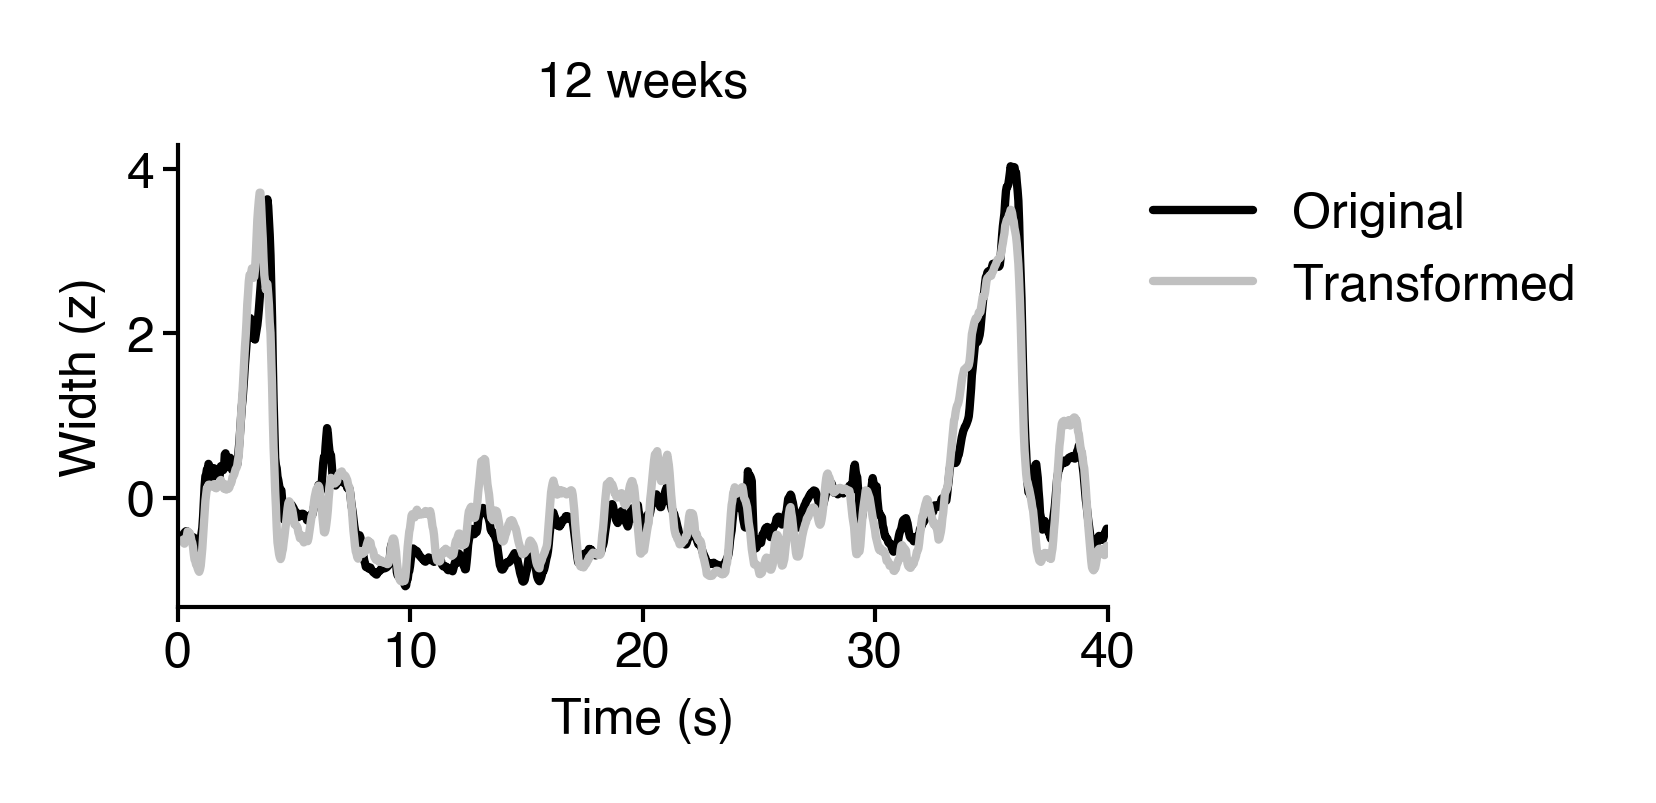

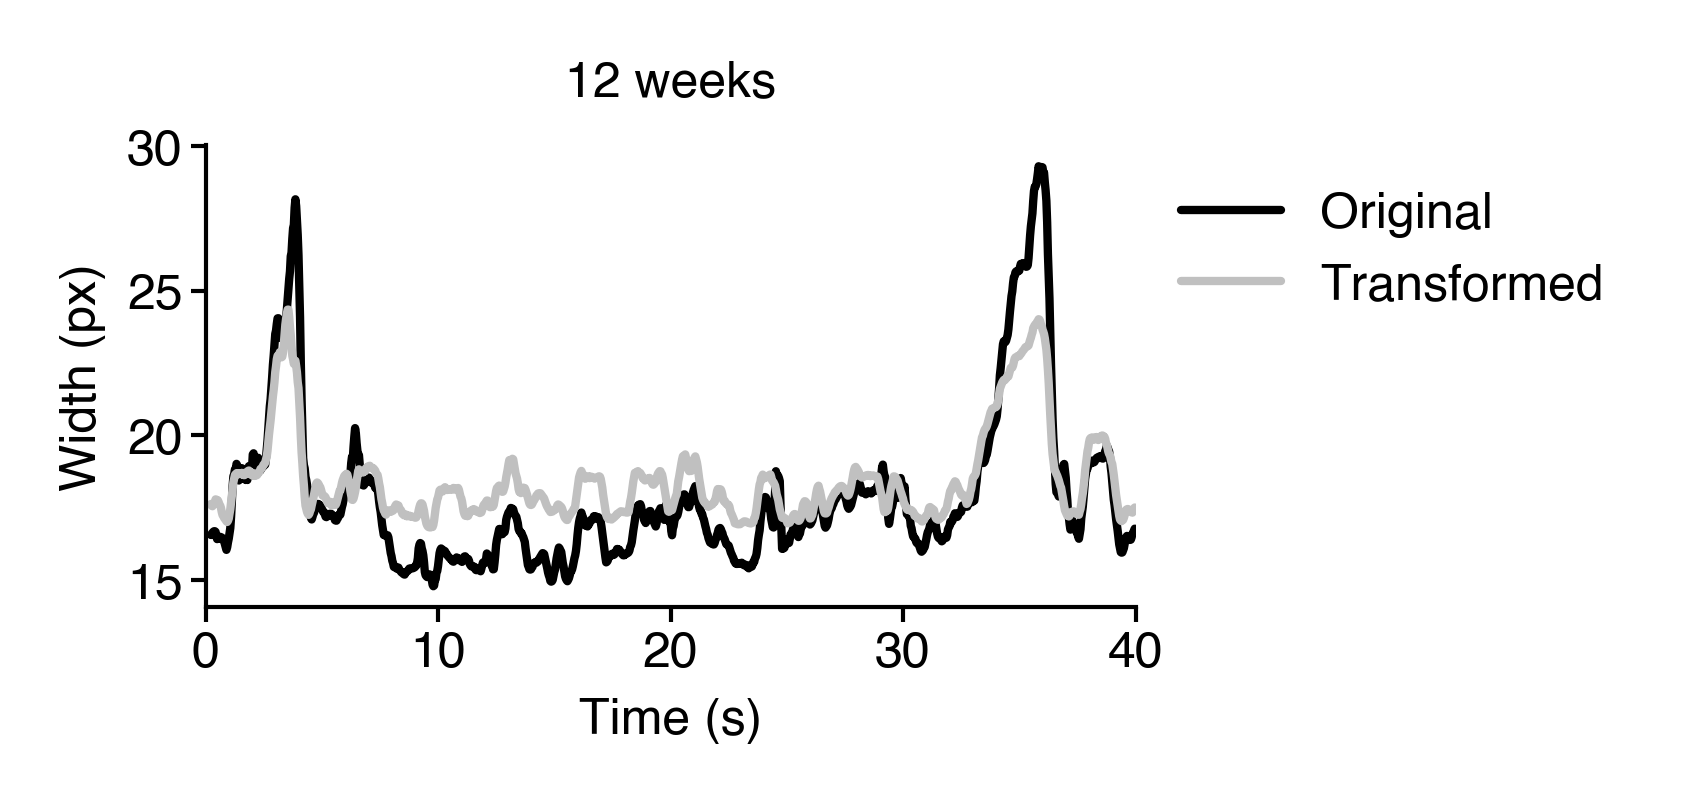

In [53]:
fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, w1, label="Original", color="k")
ax.plot(time, w2, label="Transformed", color="silver")
ax.set(xlabel="Time (s)", ylabel="Width (z)", title="12 weeks", xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, "dynamics-example-12-wks")

fig = figure(2, 1)
ax = fig.gca()
ax.plot(time, ww1, label="Original", color="k")
ax.plot(time, ww2, label="Transformed", color="silver")
ax.set(xlabel="Time (s)", ylabel="Width (px)", title="12 weeks", xlim=(0, 40))
legend(ax)
sns.despine()
saver(fig, "dynamics-example-raw-12-wks");

## Compute changepoints

In [20]:
from aging.plotting import IMG_KWARGS
from sklearn.random_projection import GaussianRandomProjection

In [21]:
def compute_changepoints(frames, mdl=None, k=5, sig=3):
    if mdl is None:
        mdl = GaussianRandomProjection(n_components=300, random_state=0)
        proj = mdl.fit_transform(flatten(frames))
    else:
        proj = mdl.transform(flatten(frames))

    proj_df = pd.DataFrame(zscore(zscore(proj).T).T, index=np.arange(len(proj)) / 30)
    proj_df_smooth = (
        proj_df.rolling(sig * 4, win_type="gaussian", center=True)
        .mean(std=sig)
        .dropna()
    )
    squared_diff = np.square(proj_df_smooth.diff(k)).shift(-k // 2)
    cp = squared_diff.mean(axis="columns")

    return cp, proj_df_smooth, mdl


def imshow(fig, data, cmap, lims):
    ax = fig.gca()
    ax.imshow(
        data,
        cmap=cmap,
        vmin=-lims,
        vmax=lims,
        extent=(0, data.shape[1] / 30, 0, len(data)),
        **IMG_KWARGS
    )
    ax.set(yticks=[], xlabel="Time (s)", ylabel="Random projections")
    return ax


def plot_changepoints(
    frames, recon_frames, cmap="RdBu_r", lims=1.5, start_idx=0, n_frames=750
):
    cp, proj_df, mdl = compute_changepoints(frames)
    cp_t, proj_df_t, _ = compute_changepoints(recon_frames, mdl)

    fig1 = figure(2, 0.5)
    ax = imshow(fig1, proj_df.iloc[start_idx : start_idx + n_frames].T, cmap, lims)

    fig2 = figure(2, 0.5)
    ax = imshow(fig2, proj_df_t.iloc[start_idx : start_idx + n_frames].T, cmap, lims)
    fig3 = figure(2, 0.7)
    ax = fig3.gca()
    ax.plot(
        np.arange(n_frames) / 30,
        cp_t.iloc[start_idx : start_idx + n_frames],
        color="k",
        label="Transformed",
    )
    ax.plot(
        np.arange(n_frames) / 30,
        cp.iloc[start_idx : start_idx + n_frames],
        color="silver",
        label="Original",
        alpha=0.9,
    )
    legend(ax)
    ax.set(ylabel="Changepoint score (a.u.)", xlabel="Time (s)", xlim=(0, 25))
    sns.despine(ax=ax)

    return fig1, fig2, fig3

In [22]:
cmap = "RdBu_r"
lims = 1.5

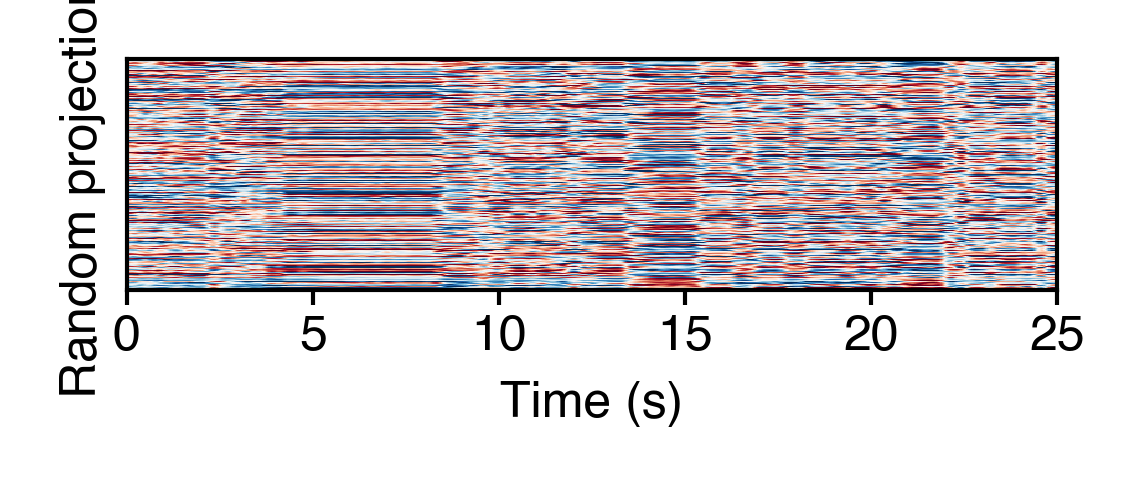

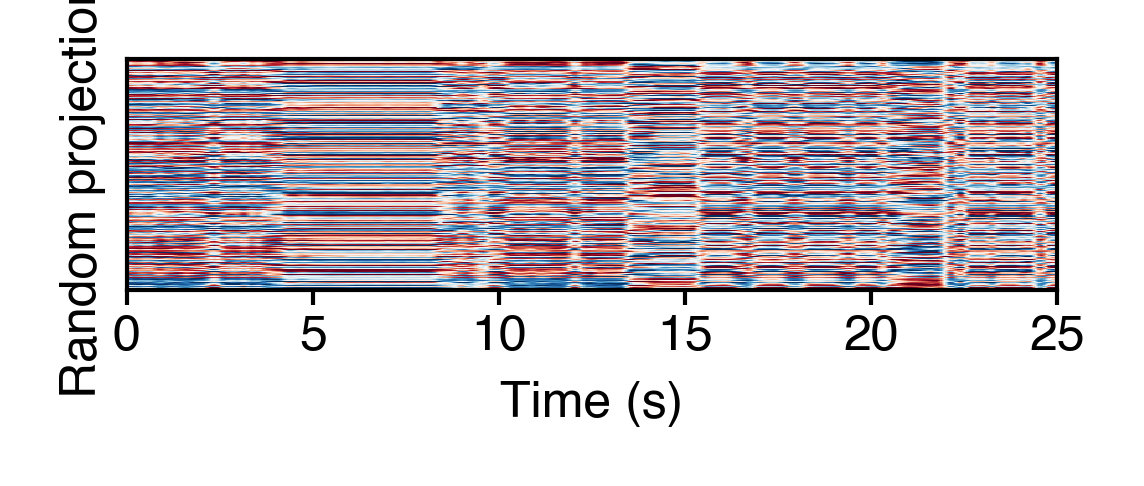

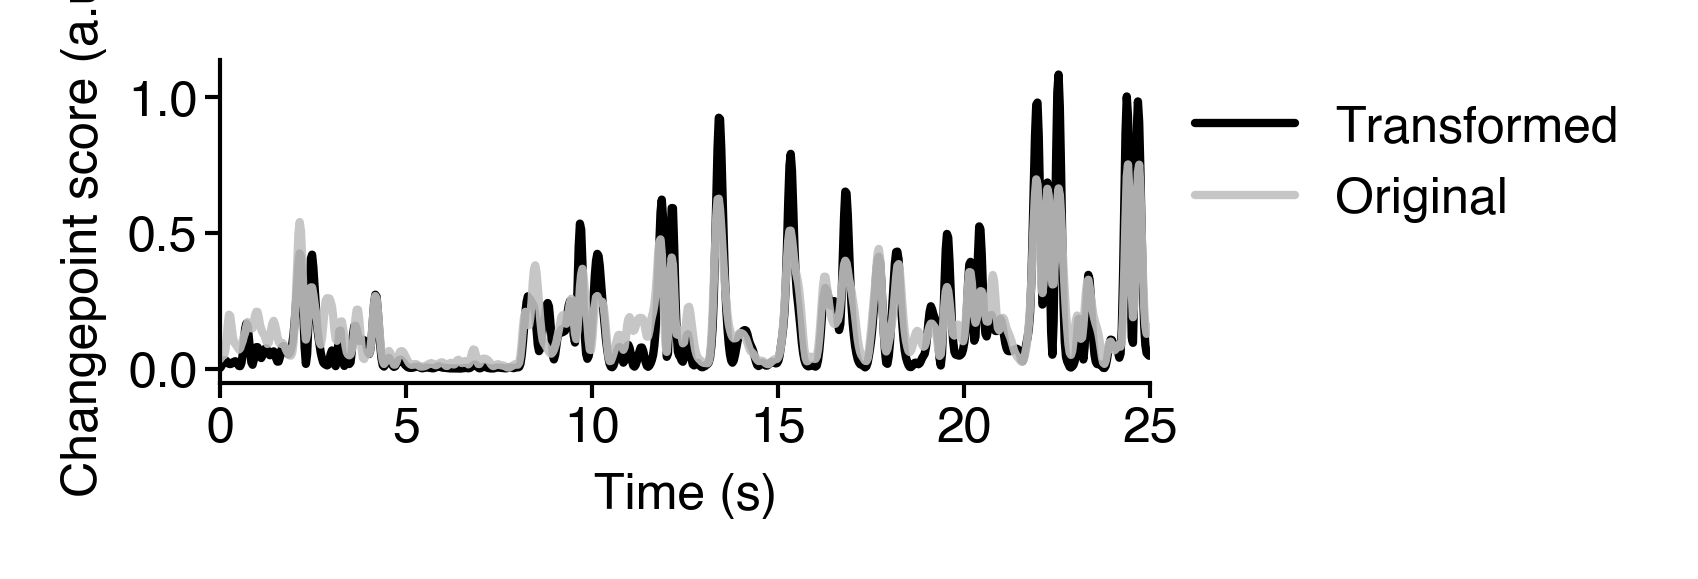

In [26]:
age = 84
session_idx = 1
frames = frames_dict[age][session_idx]
frames = np.array(list(map(clean, frames)))
transformed_frames = recon_frames_dict[age][session_idx]

figs = plot_changepoints(
    frames, transformed_frames, start_idx=1200, cmap=cmap, lims=lims
)
saver(figs[0], f'rps-{age}w-raw')
saver(figs[1], f'rps-{age}w-transformed')
saver(figs[2], f'cps-{age}w');

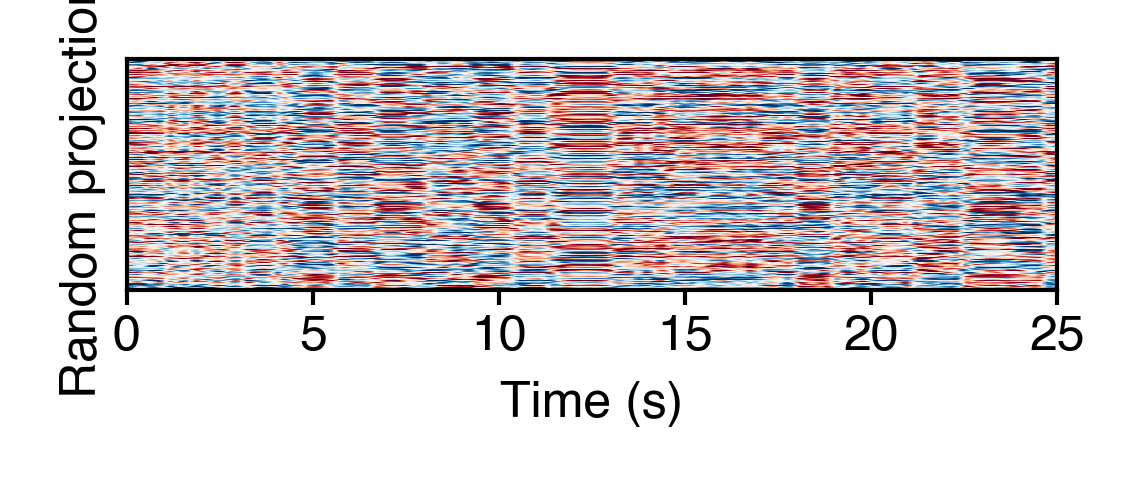

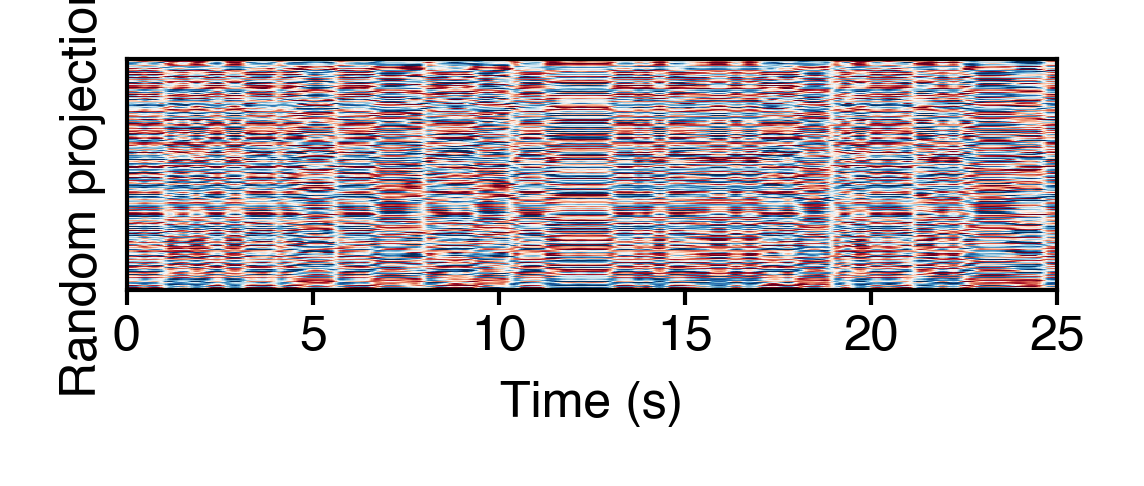

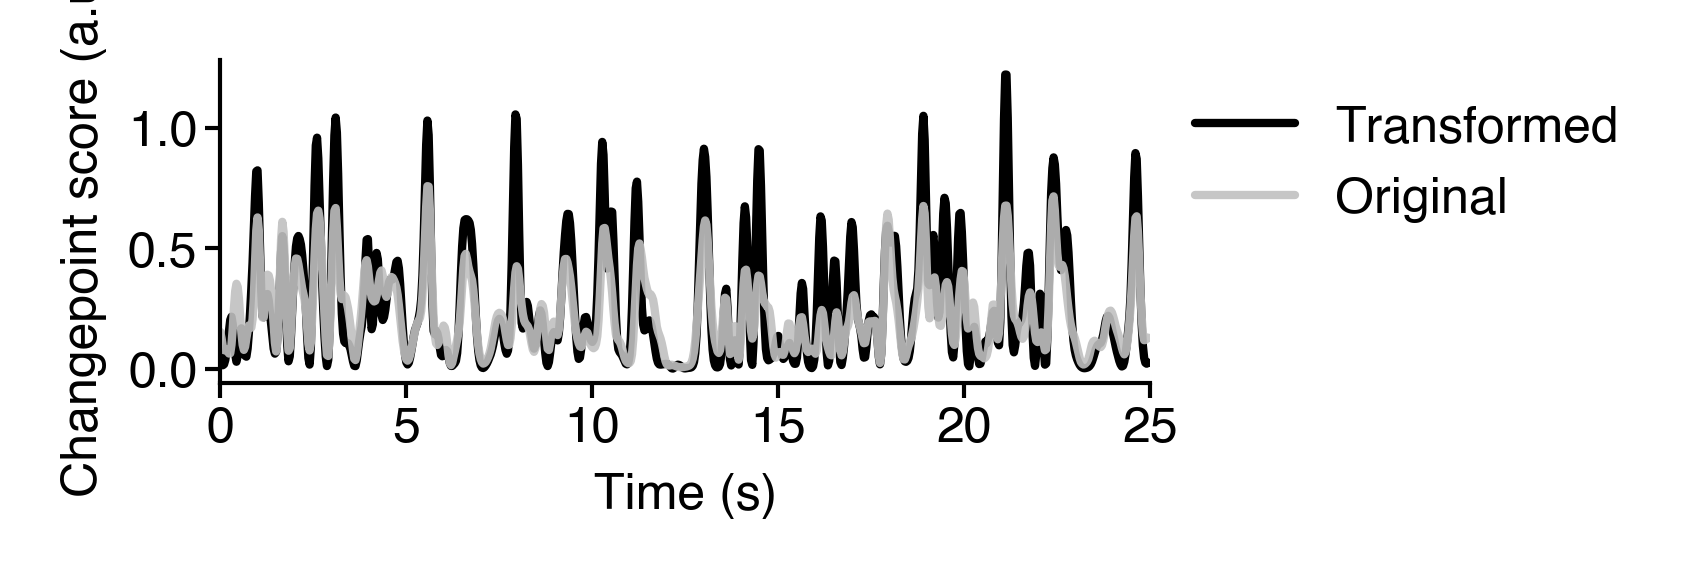

In [27]:
age = 4
session_idx = 1
frames = frames_dict[age][session_idx]
frames = np.array(list(map(clean, frames)))
transformed_frames = recon_frames_dict[age][session_idx]

figs = plot_changepoints(
    frames, transformed_frames, start_idx=2500, cmap=cmap, lims=lims
)
saver(figs[0], f'rps-{age}w-raw')
saver(figs[1], f'rps-{age}w-transformed')
saver(figs[2], f'cps-{age}w');

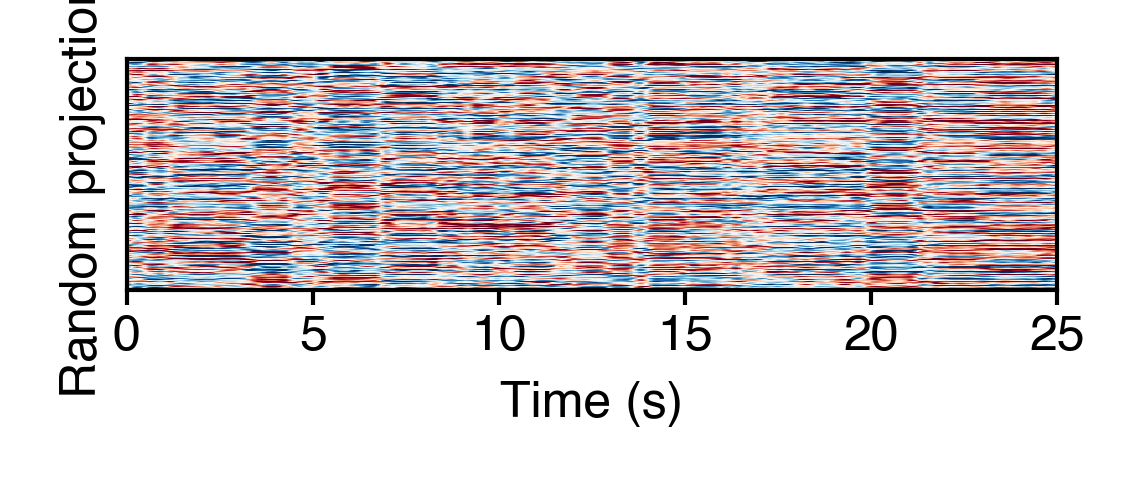

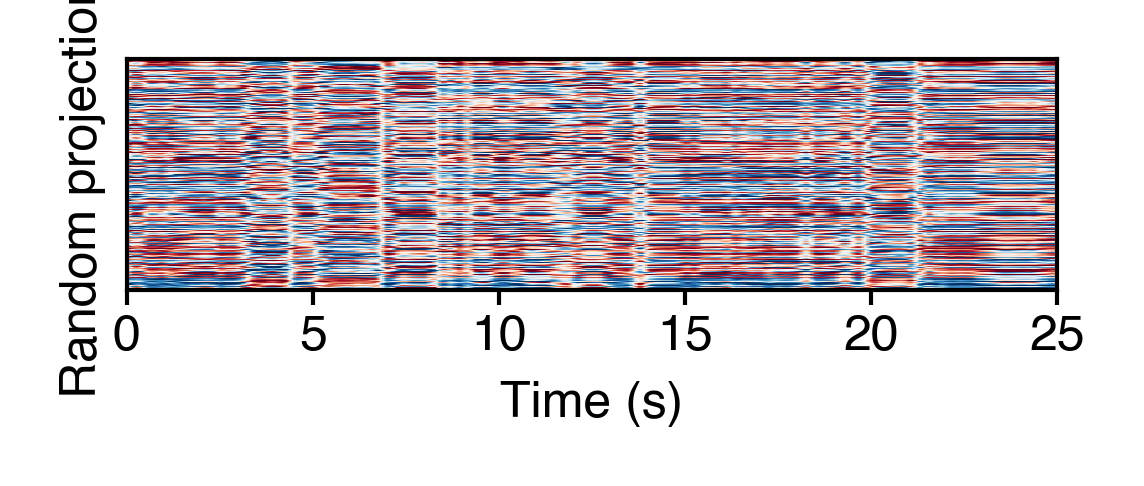

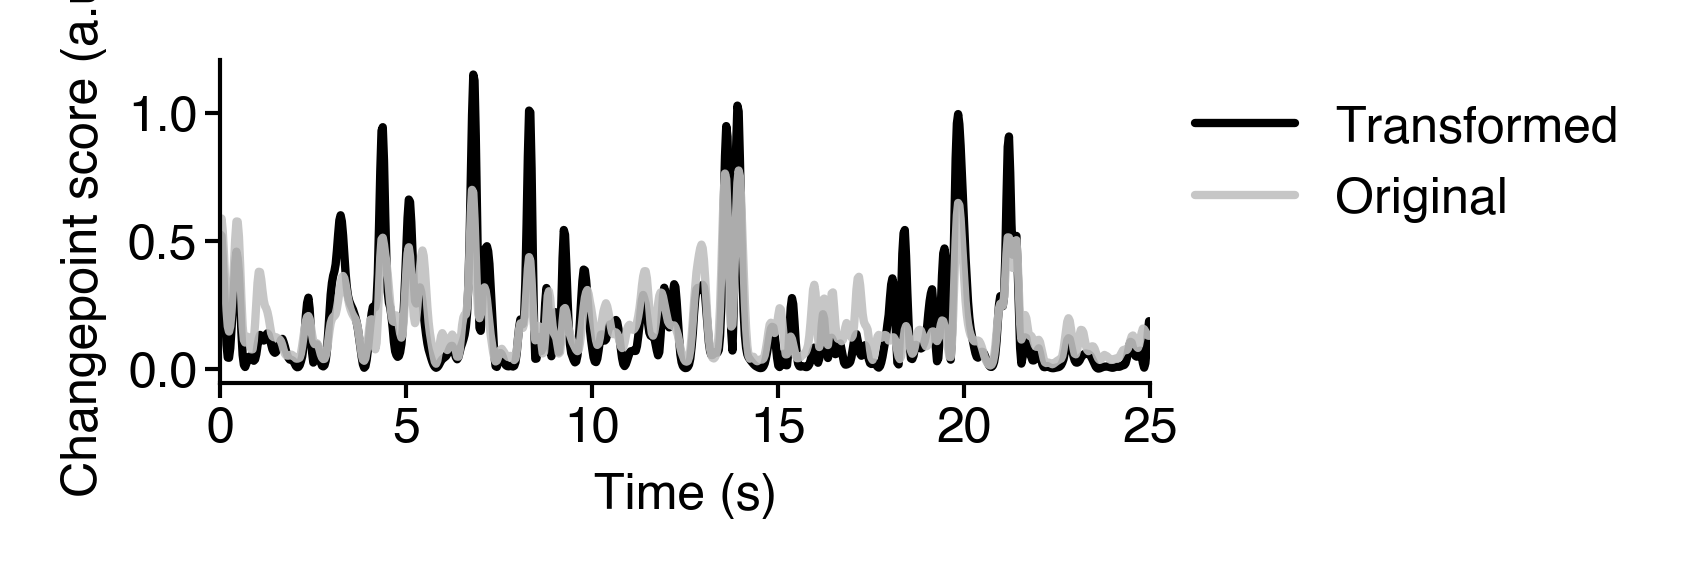

In [29]:
age = 12
session_idx = 1
frames = frames_dict[age][session_idx]
frames = np.array(list(map(clean, frames)))
transformed_frames = recon_frames_dict[age][session_idx]

figs = plot_changepoints(
    frames, transformed_frames, start_idx=2000, cmap=cmap, lims=lims
)
saver(figs[0], f'rps-{age}w-raw')
saver(figs[1], f'rps-{age}w-transformed')
saver(figs[2], f'cps-{age}w');

### Compute changepoint correlations

In [23]:
from collections import defaultdict

In [24]:
cp_dict = defaultdict(list)
for k, v in tqdm(frames_dict.items()):
    for frames, recon_frames in zip(v, recon_frames_dict[k]):
        cp, _, mdl = compute_changepoints(frames)
        cp_t, _, _ = compute_changepoints(recon_frames, mdl=mdl)

        c = cp.corr(cp_t)
        cp_dict[k].append(c)

  0%|          | 0/24 [00:00<?, ?it/s]

In [25]:
cp_df = pd.concat((pd.DataFrame({"corr": d, "Age": k}) for k, d in cp_dict.items()), ignore_index=True)

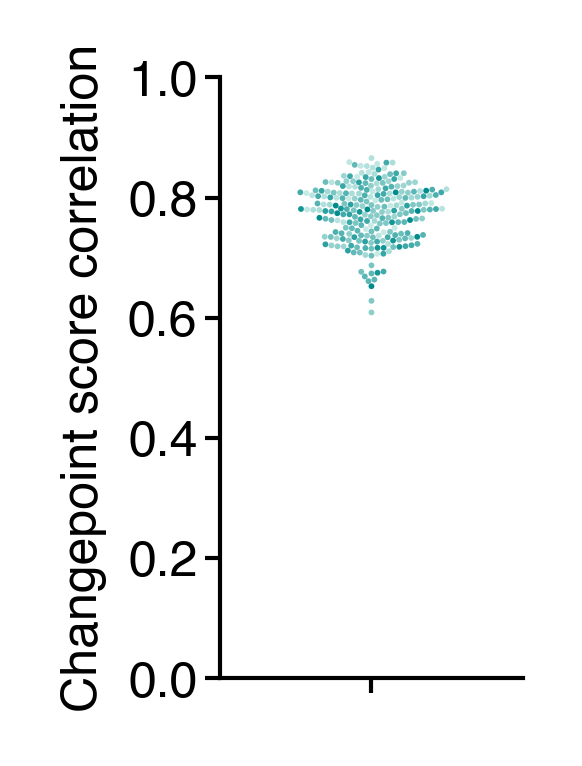

In [26]:
fig = figure(0.65, 1.3)
ax = sns.swarmplot(
    data=cp_df,
    y="corr",
    hue="Age",
    palette=female_cmap,
    size=0.7,
    legend=False,
)
ax.set(ylim=(0, 1), ylabel="Changepoint score correlation")
sns.despine()
saver(fig, "cps-correlation-vs-age-swarmplot");